<a href="https://colab.research.google.com/github/kaylaque/glauco-scan/blob/main/%5BKeras_2_4_0_PreTrained%5D_U_Net%2C_OD_on_RIM_ONE_v3_(fold_0).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip uninstall keras -y
!pip uninstall keras-nightly -y
!pip uninstall keras-Preprocessing -y
!pip uninstall keras-vis -y
!pip uninstall tensorflow -y

!pip install tensorflow==2.3.0
!pip install keras==2.4
!pip install git+https://github.com/qubvel/segmentation_models
!pip install mahotas

Found existing installation: Keras 2.4.3
Uninstalling Keras-2.4.3:
  Successfully uninstalled Keras-2.4.3
Found existing installation: keras-nightly 2.5.0.dev2021032900
Uninstalling keras-nightly-2.5.0.dev2021032900:
  Successfully uninstalled keras-nightly-2.5.0.dev2021032900
Found existing installation: Keras-Preprocessing 1.1.2
Uninstalling Keras-Preprocessing-1.1.2:
  Successfully uninstalled Keras-Preprocessing-1.1.2
Found existing installation: keras-vis 0.4.1
Uninstalling keras-vis-0.4.1:
  Successfully uninstalled keras-vis-0.4.1
Found existing installation: tensorflow 2.5.0
Uninstalling tensorflow-2.5.0:
  Successfully uninstalled tensorflow-2.5.0
     |████████████████████████████████| 320.4 MB 45 kB/s 
     |████████████████████████████████| 20.1 MB 1.2 MB/s 
     |████████████████████████████████| 42 kB 1.7 MB/s 
     |████████████████████████████████| 2.9 MB 57.7 MB/s 
     |████████████████████████████████| 459 kB 59.5 MB/s 
  Attempting uninstall: numpy
    Found existin

     |████████████████████████████████| 170 kB 7.5 MB/s 
  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-y_lovttr
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-y_lovttr
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 50 kB 3.9 MB/s 
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33809 sha256=9ea902c5fd960bd064099016c4725cbc96bde4dada9ff8deac95656e6fbeced4
  Stored in directory: /tmp/pip-ephem-wheel-cache-qllomp5j/wheels/02/cd/18/61c0bbb8766acfec68f9d20618886b7b38dfeeb95865b6ba00
Successfully built segmentation-models
     |████████████████████████████████| 5.7 MB 6.5 MB/s 


In [ ]:
%cd /content/drive/MyDrive/HackathonIGI/optic-nerve-cnn-1.0.0/scripts

/content/drive/MyDrive/HackathonIGI/optic-nerve-cnn-1.0.0/scripts


Restart your runtime after do pip install above


### Training of modified U-Net for Optic Disc on RIM-ONE v3 database, 256 px images (cross-validation fold #0).

You can either train your model or upload a pre-trained one from:
*../models_weights/03.03,14:19,U-Net light, on RIM-ONE v3 256 px fold 0, SGD, high augm, CLAHE, log_dice loss/last_checkpoint.hdf5*.

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import glob
from datetime import datetime
#import warnings
#warnings.simplefilter('ignore')
import scipy as sp
import scipy.ndimage
import numpy as np
import pandas as pd
import skimage
import skimage.exposure
import mahotas as mh
from sklearn.model_selection import KFold
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from tqdm import tqdm_notebook
from IPython.display import display
from dual_IDG import DualImageDataGenerator

Using TensorFlow backend.


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, \
    Convolution2D, MaxPooling2D, ZeroPadding2D, Input, Embedding, LSTM, merge, \
    Lambda, UpSampling2D, Cropping2D
from keras.utils import np_utils
from keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

In [ ]:
K.set_image_data_format('channels_first')

In [ ]:
def mean_IOU_cpu_for_binary(X, Y):
    """Computes mean Intersection-over-Union (IOU) for two arrays of binary images.
    Assuming X and Y are of shape (n_images, w, h)."""
    
    intersection, union = np.logical_and(X, Y).sum(axis=(1, 2, 3)), np.logical_or(X, Y).sum(axis=(1, 2, 3))
    # if union == 0, it follows that intersection == 0 => score should be 0.
    union = np.where(union == 0, 1, union)
    return np.mean(intersection / union.astype(np.float64))


def mean_IOU_cpu(X, Y):
    X_fl = X > 0.5
    Y_fl = Y > 0.5
    
    intersection = K.sum(X_fl * Y_fl, axis=1)
    union = K.sum(K.maximum(X_fl, Y_fl), axis=1)
    # if union == 0, it follows that intersection == 0 => score should be 0.
    union = K.switch(K.equal(union, 0), 1, union)
    return K.mean(intersection / K.cast(union, 'float32'))

In [ ]:
def mean_IOU_gpu(X, Y):
    """Computes mean Intersection-over-Union (IOU) for two arrays of binary images.
    Assuming X and Y are of shape (n_images, w, h)."""
    
    #X_fl = K.clip(K.batch_flatten(X), K.epsilon(), 1.)
    #Y_fl = K.clip(K.batch_flatten(Y), K.epsilon(), 1.)
    X_fl = K.clip(K.batch_flatten(X), 0., 1.)
    Y_fl = K.clip(K.batch_flatten(Y), 0., 1.)
    X_fl = K.greater(X_fl, 0.5)
    Y_fl = K.greater(Y_fl, 0.5)
    
    intersection = K.sum(X_fl * Y_fl, axis=1)
    union = K.sum(K.maximum(X_fl, Y_fl), axis=1)
    # if union == 0, it follows that intersection == 0 => score should be 0.
    union = K.switch(K.equal(union, 0), 1, union)
    return K.mean(intersection / K.cast(union, 'float32'))


def mean_IOU_gpu_for_flattened(x, y):
    x = K.clip(x, K.epsilon(), 1.)
    y = K.clip(y, K.epsilon(), 1.)
    x = K.greater(x, 0.5)
    y = K.greater(y, 0.5)
    
    intersection = K.sum(x * y, axis=1)
    union = K.sum(K.maximum(x, y), axis=1)
    # if union == 0, it follows that intersection == 0 => score should be 0.
    union = K.switch(K.equal(union, 0), 1, union)
    return K.mean(intersection / K.cast(union, 'float32'))


def mean_IOU_gpu_loss(X, Y):
    return -mean_IOU_gpu(X, Y)

In [ ]:
def bce_gpu(y_true, y_pred):
    # Credits: https://www.kaggle.com/c/ultrasound-nerve-segmentation/forums/t/22951/would-like-to-see-how-others-approached-this-problem-doesn-t-have-to-be/131719
    
    # Workaround for shape bug.
    #y_true.set_shape(y_pred.get_shape())

    # Without K.clip, K.sum() behaves differently when compared to np.count_nonzero()
    y_true_f = K.clip(K.batch_flatten(y_true), K.epsilon(), 1.)
    y_pred_f = K.clip(K.batch_flatten(y_pred), K.epsilon(), 1.)
    
    bce = K.mean(K.binary_crossentropy(y_true_f, y_pred_f), axis=-1)
    return K.mean(bce)

In [ ]:
def dice(y_true, y_pred):
    # Workaround for shape bug. For some reason y_true shape was not being set correctly
    #y_true.set_shape(y_pred.get_shape())

    # Without K.clip, K.sum() behaves differently when compared to np.count_nonzero()
    #y_true_f = K.clip(K.batch_flatten(y_true), K.epsilon(), 1.)
    #y_pred_f = K.clip(K.batch_flatten(y_pred), K.epsilon(), 1.)
    y_true_f = K.clip(K.batch_flatten(y_true), 0., 1.)
    y_pred_f = K.clip(K.batch_flatten(y_pred), 0., 1.)
    #y_pred_f = K.greater(y_pred_f, 0.5)

    intersection = 2 * K.sum(y_true_f * y_pred_f, axis=1)
    union = K.sum(y_true_f * y_true_f, axis=1) + K.sum(y_pred_f * y_pred_f, axis=1)
    return K.mean(intersection / union)


def dice_loss(y_true, y_pred):
    return -dice(y_true, y_pred)


def log_dice_loss(y_true, y_pred):
    return -K.log(dice(y_true, y_pred))


def dice_metric(y_true, y_pred):
    """An exact Dice score for binary tensors."""
    y_true_f = K.greater(y_true, 0.5)
    y_pred_f = K.greater(y_pred, 0.5)
    return dice(y_true_f, y_pred_f)

In [ ]:
def tf_to_th_encoding(X):
    return np.rollaxis(X, 3, 1)


def th_to_tf_encoding(X):
    return np.rollaxis(X, 1, 4)

In [ ]:
#h5f = h5py.File("../data/hdf5_datasets/all_data.hdf5", "r")

# h5f = h5py.File("../data/hdf5_datasets/RIM_ONE_v3.hdf5", "r")

h5f = h5py.File("/content/drive/MyDrive/HackathonIGI/optic-nerve-cnn-1.0.0/Glaucoma paper - datasets/RIM_ONE_v3.hdf5", "r")

### UNet with Efficient Net


#### RIM-ONE v3

Accessing data, preparing train/validation sets division:

In [ ]:
X = h5f['RIM-ONE v3/256 px/images']
Y = h5f['RIM-ONE v3/256 px/disc']

In [ ]:
X, Y

(<HDF5 dataset "images": shape (159, 256, 256, 3), type "|u1">,
 <HDF5 dataset "disc": shape (159, 256, 256, 1), type "|u1">)

In [ ]:
train_idx_cv, test_idx_cv = [], []

for _train_idx, _test_idx in KFold(n_splits=5, random_state=1).split(X):
    print(_train_idx, _test_idx)
    train_idx_cv.append(_train_idx)
    test_idx_cv.append(_test_idx)

[ 32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49
  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85
  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139
 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157
 158] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  64  65  66  67
  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85
  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123 124 125 12

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [ ]:
#train_idx = h5f['RIM-ONE v3/train_idx_driu']
#test_idx = h5f['RIM-ONE v3/test_idx_driu']

train_idx = train_idx_cv[0]
test_idx = test_idx_cv[0]

In [ ]:
len(X), len(train_idx), len(test_idx)

(159, 127, 32)

#### Generator of augmented data:

In [ ]:
train_idg = DualImageDataGenerator(#rescale=1/255.0,
                                   #samplewise_center=True, samplewise_std_normalization=True,
                                   horizontal_flip=True, vertical_flip=True,
                                   rotation_range=50, width_shift_range=0.15, height_shift_range=0.15,
                                   zoom_range=(0.7, 1.3),
                                   fill_mode='constant', cval=0.0)
test_idg = DualImageDataGenerator()

channels_first
channels_first


#### Preprocessing function and data generator:

In [ ]:
def preprocess(batch_X, batch_y, train_or_test='train'):
    batch_X = batch_X / 255.0
    batch_y = batch_y / 255.0
    if train_or_test == 'train':
        batch_X, batch_y = train_idg.flow(batch_X, batch_y, batch_size=len(batch_X), shuffle=False).next()
    elif train_or_test == 'test':
        batch_X, batch_y = test_idg.flow(batch_X, batch_y, batch_size=len(batch_X), shuffle=False).next()
    batch_X = th_to_tf_encoding(batch_X)
    batch_X = [skimage.exposure.equalize_adapthist(batch_X[i]) 
               for i in range(len(batch_X))]
    batch_X = np.array(batch_X)
    batch_X = tf_to_th_encoding(batch_X)
    return batch_X, batch_y


def data_generator(X, y, train_or_test='train', batch_size=3, return_orig=False, stationary=False):    
    while True:
        if train_or_test == 'train':
            idx = np.random.choice(train_idx, size=batch_size)
        elif train_or_test == 'test':
            if stationary:
                idx = test_idx[:batch_size]
            else:
                idx = np.random.choice(test_idx, size=batch_size)
        batch_X = [X[i] for i in idx]
        batch_X = np.array(batch_X).copy()
        batch_y = [y[i] for i in idx]
        batch_y = np.array(batch_y).copy()
        batch_X = tf_to_th_encoding(batch_X)
        batch_y = tf_to_th_encoding(batch_y)
        if return_orig:
            batch_X_orig, batch_Y_orig = batch_X.copy(), batch_y.copy()
        
        batch_X, batch_y = preprocess(batch_X, batch_y, train_or_test)
        
        if not return_orig:
            yield batch_X, batch_y
        else:
            yield batch_X, batch_y, batch_X_orig, batch_Y_orig

Testing the data generator and generator for augmented data:

In [ ]:
gen = data_generator(X, Y, 'train', batch_size=1)
batch = gen.__next__()
batch[0].shape

(1, 3, 256, 256)

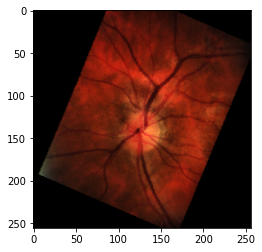

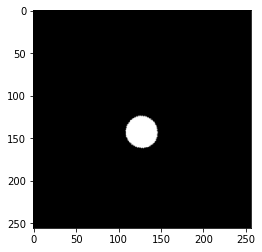

In [ ]:
fig = plt.imshow(np.rollaxis(batch[0][0], 0, 3))
#plt.colorbar(mappable=fig)
plt.show()
plt.imshow(batch[1][0][0], cmap=plt.cm.Greys_r); plt.show()

In [ ]:
arch_name = "U-Net light, on RIM-ONE v3 256 px fold 0, SGD, high augm, CLAHE, log_dice loss"
weights_folder = '../models_weights/' \
                 '{},{}/'.format(datetime.now().strftime('%d.%m,%H:%M'), arch_name)

In [ ]:
weights_folder

'../models_weights/29.07,01:40,U-Net light, on RIM-ONE v3 256 px fold 0, SGD, high augm, CLAHE, log_dice loss/'

In [ ]:
def folder(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    return folder_name

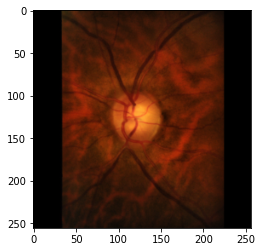

(32, 3, 256, 256) (32, 1, 256, 256)


In [ ]:
X_valid, Y_valid = data_generator(X, Y, train_or_test='test', batch_size=100, stationary=True).__next__()
plt.imshow(np.rollaxis(X_valid[0], 0, 3)); plt.show()
print(X_valid.shape, Y_valid.shape)

### [API Segmentation](https://github.com/qubvel/segmentation_models)

In [ ]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [ ]:

#Resnet34 freeze pre trained model
arch_name = "OD Cup, U-Net Resnet34 freeze RIM-ONE fold 0, SGD, Dice Loss"
weights_folder = os.path.join(os.path.dirname(os.getcwd()), 'models_weights',
                              '{},{}'.format(datetime.now().strftime('%d.%m,%H:%M'), arch_name))
print(weights_folder)
BACKBONE = 'resnet34'

# define model
model_freeze = sm.Unet(BACKBONE, input_shape = (3, None, None), classes=1, encoder_weights='imagenet', encoder_freeze = True)
model_freeze.compile(
    SGD(lr=1e-4, momentum=0.95),
    loss=sm.losses.DiceLoss(),
    metrics=[sm.metrics.iou_score, sm.metrics.FScore()]   
)

# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
hitory_f = model_freeze.fit(
   data_generator(X, Y, train_or_test='train', batch_size=1),
   batch_size=16,
   epochs=100,
   steps_per_epoch=1000,
   validation_data=(X_valid, Y_valid),
   callbacks=[CSVLogger(os.path.join(folder(weights_folder), 'training_log.csv')),
                                         #ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.5, verbose=1, patience=40),
                                         ModelCheckpoint(os.path.join(folder(weights_folder),
                                               #'weights.ep-{epoch:02d}-val_mean_IOU-{val_mean_IOU_gpu:.2f}_val_loss_{val_loss:.2f}.hdf5',
                                               'last_checkpoint.hdf5'),
                                               monitor='val_loss', mode='min', save_best_only=True, 
                                               save_weights_only=False, verbose=0)]
)

/content/drive/.shortcut-targets-by-id/12t2R9OHxEvJh_1d4iKHKB0jDu4V5FvzQ/HackathonIGI/optic-nerve-cnn-1.0.0/models_weights/28.07,15:41,OD Cup, U-Net Resnet34 freeze RIM-ONE fold 0, SGD, Dice Loss
Epoch 1/100
1000/1000 [==============================] - 98s 98ms/step - loss: 0.8023 - iou_score: 0.1144 - f1-score: 0.1977 - val_loss: 0.9576 - val_iou_score: 0.0216 - val_f1-score: 0.0424
Epoch 2/100
1000/1000 [==============================] - 96s 96ms/step - loss: 0.2954 - iou_score: 0.5581 - f1-score: 0.7046 - val_loss: 0.5331 - val_iou_score: 0.3067 - val_f1-score: 0.4669
Epoch 3/100
1000/1000 [==============================] - 96s 96ms/step - loss: 0.1663 - iou_score: 0.7207 - f1-score: 0.8337 - val_loss: 0.3601 - val_iou_score: 0.4705 - val_f1-score: 0.6399
Epoch 4/100
1000/1000 [==============================] - 96s 96ms/step - loss: 0.1350 - iou_score: 0.7666 - f1-score: 0.8650 - val_loss: 0.2637 - val_iou_score: 0.5828 - val_f1-score: 0.7363
Epoch 5/100
1000/1000 [=================

In [ ]:
def evaluate_model_(history):
    names = [['iou_score', 'val_iou_score'], 
             ['loss', 'val_loss'], 
             ['f1-score', 'val_f1-score']]
            #  ['recall', 'val_recall'], ['precision', 'val_precision']]
    for name in names :
        fig1, ax_acc = plt.subplots()
        plt.plot(history.history[name[0]])
        plt.plot(history.history[name[1]])
        plt.xlabel('Epoch')
        plt.ylabel(name[0])
        plt.title('Model - ' + name[0])
        plt.legend(['Training', 'Validation'], loc='lower right')
        plt.show()
        
# evaluate_model_(hitory_f)

In [ ]:
from keras.models import model_from_json
# serialize model to JSON
model_json = model_eff.to_json()
with open("model_effnet.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
#Efficientnetb7 freeze pre trained model
arch_name = "OD Cup, U-Net efficientnetb7 freeze DRISHTI-GS 512 px cropped to OD 128 px fold 0, Adam, Dice Loss"
weights_folder = os.path.join(os.path.dirname(os.getcwd()), 'models_weights',
                              '{},{}'.format(datetime.now().strftime('%d.%m,%H:%M'), arch_name))
print(weights_folder)
BACKBONE = 'efficientnetb7'
# preprocess_input = sm.get_preprocessing(BACKBONE)
# gen = data_generator(X, Y, 128, 'train', batch_size=1)
# x_train, y_train = next(gen)

# # # preprocess input
# x_train = preprocess_input(x_train)
# x_val = preprocess_input(X_valid)

# define model
model_eff = sm.Unet(BACKBONE, input_shape = (3, None, None), classes=1, encoder_weights='imagenet', encoder_freeze = True)
model_eff.compile(
    SGD(lr=1e-4, momentum=0.95),
    loss=sm.losses.DiceLoss(),
    metrics=[sm.metrics.iou_score, sm.metrics.FScore()]
)

# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
history = model_eff.fit(
   data_generator(X, Y, train_or_test='train', batch_size=1),
   batch_size=16,
   epochs=500,
   steps_per_epoch=99,
   validation_data=(X_valid, Y_valid),
   callbacks=[CSVLogger(os.path.join(folder(weights_folder), 'training_log.csv')),
                                         #ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.5, verbose=1, patience=40),
                                         ModelCheckpoint(os.path.join(folder(weights_folder),
                                               #'weights.ep-{epoch:02d}-val_mean_IOU-{val_mean_IOU_gpu:.2f}_val_loss_{val_loss:.2f}.hdf5',
                                               'last_checkpoint.hdf5'),
                                               monitor='val_loss', mode='min', save_best_only=True, 
                                               save_weights_only=False, verbose=0)]
)

/content/drive/MyDrive/HackathonIGI/optic-nerve-cnn-1.0.0/models_weights/29.07,02:36,OD Cup, U-Net efficientnetb7 freeze DRISHTI-GS 512 px cropped to OD 128 px fold 0, Adam, Dice Loss
Epoch 1/500
99/99 [==============================] - 21s 209ms/step - loss: 0.9259 - iou_score: 0.0386 - f1-score: 0.0741 - val_loss: 0.9354 - val_iou_score: 0.0334 - val_f1-score: 0.0646
Epoch 2/500
99/99 [==============================] - 21s 214ms/step - loss: 0.9106 - iou_score: 0.0470 - f1-score: 0.0894 - val_loss: 0.9269 - val_iou_score: 0.0379 - val_f1-score: 0.0731
Epoch 3/500
99/99 [==============================] - 21s 212ms/step - loss: 0.8990 - iou_score: 0.0535 - f1-score: 0.1010 - val_loss: 0.9126 - val_iou_score: 0.0457 - val_f1-score: 0.0874
Epoch 4/500
99/99 [==============================] - 21s 210ms/step - loss: 0.8807 - iou_score: 0.0638 - f1-score: 0.1193 - val_loss: 0.8920 - val_iou_score: 0.0571 - val_f1-score: 0.1080
Epoch 5/500
99/99 [==============================] - 21s 216ms/s

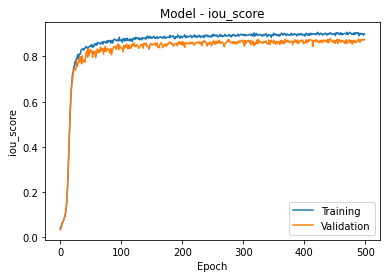

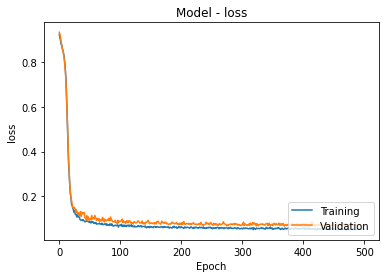

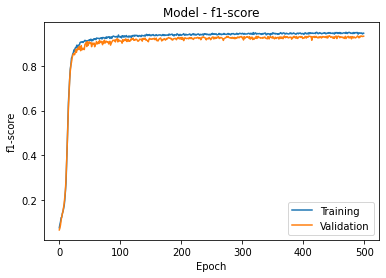

In [ ]:
evaluate_model_(history)

### Comprehensive visual check

image #0


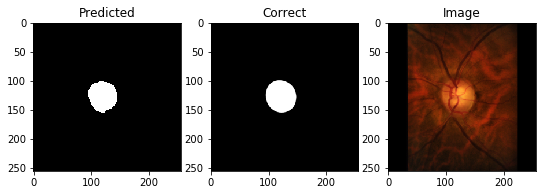

IOU: 0.8923208713531494
Dice: 0.9514854688047008
image #1


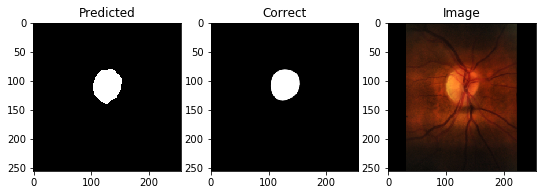

IOU: 0.9035049676895142
Dice: 0.9569133618203464
image #2


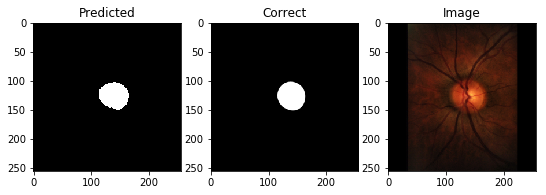

IOU: 0.8922845721244812
Dice: 0.9500142416061759
image #3


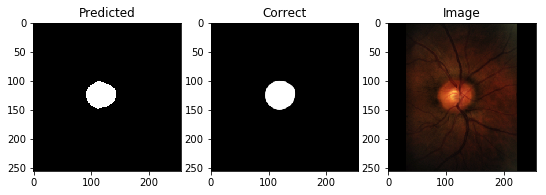

IOU: 0.8536585569381714
Dice: 0.9295054089259499
image #4


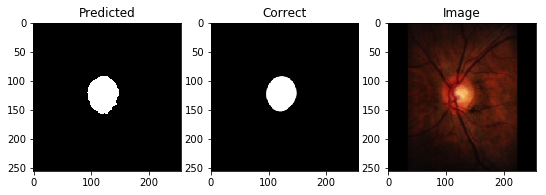

IOU: 0.9009679555892944
Dice: 0.9543506981328702
image #5


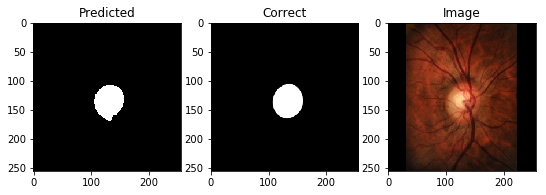

IOU: 0.9010813236236572
Dice: 0.9537108600214066
image #6


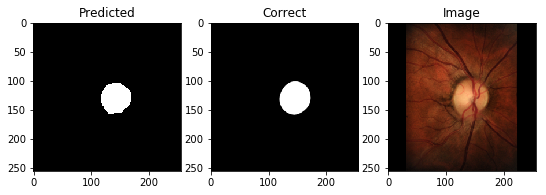

IOU: 0.8628966808319092
Dice: 0.9336332343852486
image #7


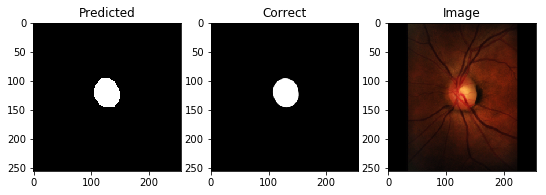

IOU: 0.8931052684783936
Dice: 0.9520771207299886
image #8


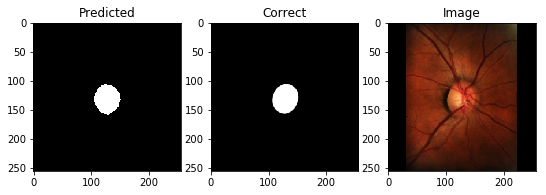

IOU: 0.9234527945518494
Dice: 0.9671544647243187
image #9


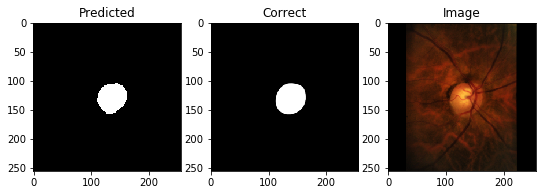

IOU: 0.8856767416000366
Dice: 0.9486175193047547
image #10


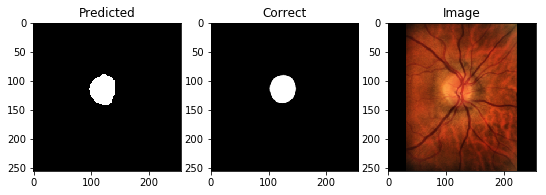

IOU: 0.7989898920059204
Dice: 0.8960907109713492
image #11


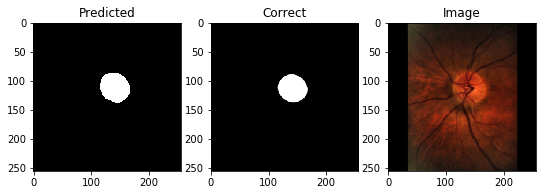

IOU: 0.8789868950843811
Dice: 0.9427118464151216
image #12


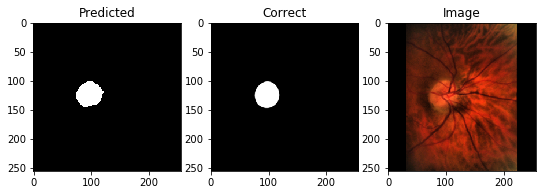

IOU: 0.9089207649230957
Dice: 0.9590989250539649
image #13


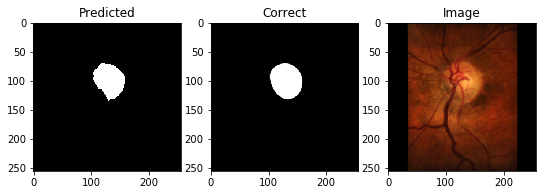

IOU: 0.8720845580101013
Dice: 0.9386928079203933
image #14


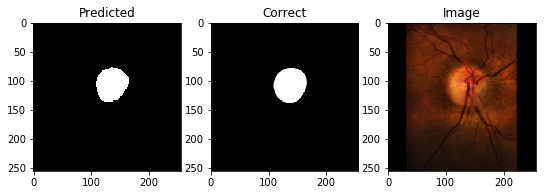

IOU: 0.921937108039856
Dice: 0.9642533757357681
image #15


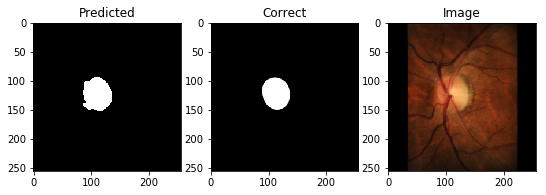

IOU: 0.8681550025939941
Dice: 0.9368440267071262
image #16


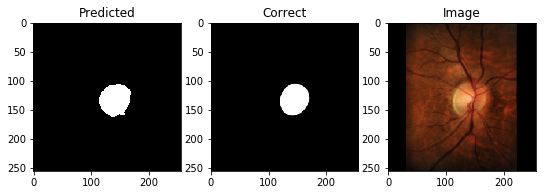

IOU: 0.8619418144226074
Dice: 0.9325311046861968
image #17


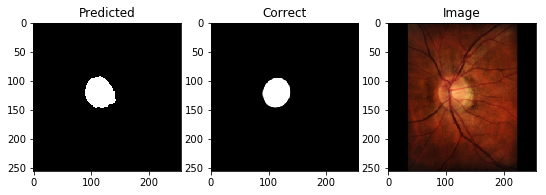

IOU: 0.838142454624176
Dice: 0.9188599640882791
image #18


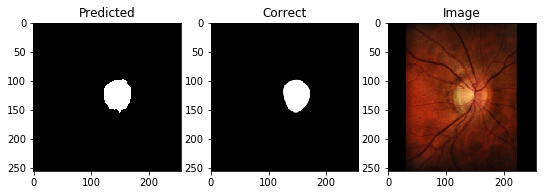

IOU: 0.8786340355873108
Dice: 0.9417755893152095
image #19


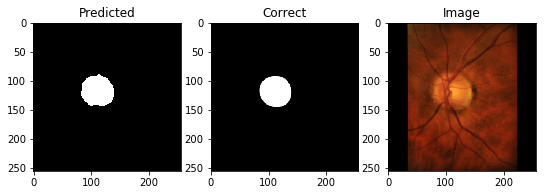

IOU: 0.9166998863220215
Dice: 0.9627739738453385
image #20


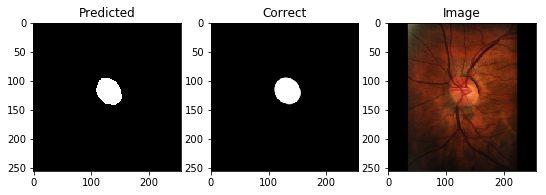

IOU: 0.9094159603118896
Dice: 0.9588825771556994
image #21


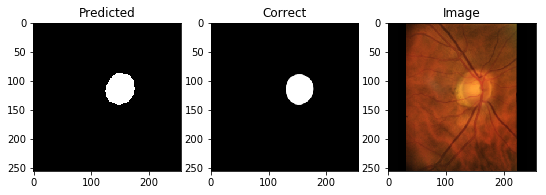

IOU: 0.8545700311660767
Dice: 0.9292909531926965
image #22


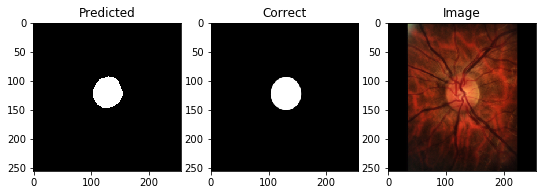

IOU: 0.895815908908844
Dice: 0.9517681866790784
image #23


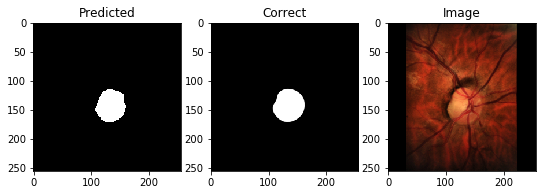

IOU: 0.9331958889961243
Dice: 0.9721364573581157
image #24


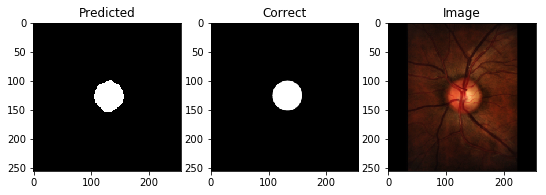

IOU: 0.9280074238777161
Dice: 0.9694889770900597
image #25


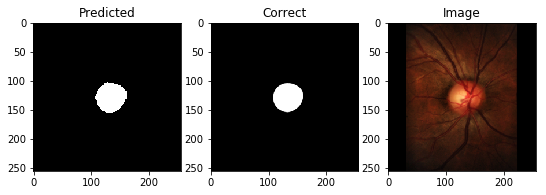

IOU: 0.9020054936408997
Dice: 0.9548999415771177
image #26


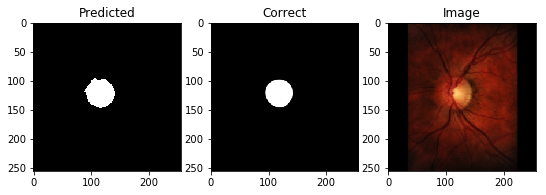

IOU: 0.8941475749015808
Dice: 0.950814471349456
image #27


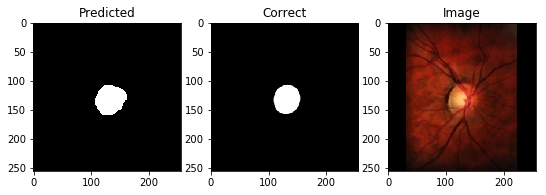

IOU: 0.8285845518112183
Dice: 0.9138837037198083
image #28


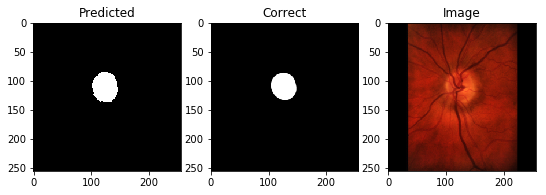

IOU: 0.8563033938407898
Dice: 0.9305397723178389
image #29


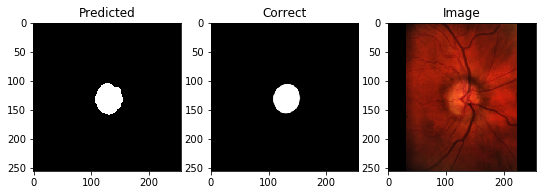

IOU: 0.9167090058326721
Dice: 0.9643001776004922
image #30


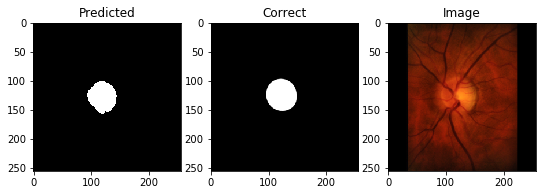

IOU: 0.8010664582252502
Dice: 0.8969654905666945
image #31


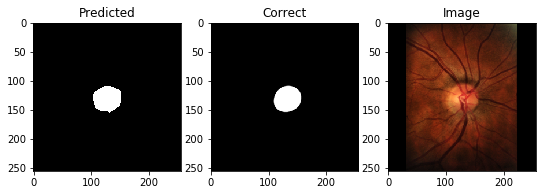

IOU: 0.8161764740943909
Dice: 0.9064875387975881


In [ ]:
pred_iou, pred_dice = [], []

for i, img_no in enumerate(test_idx):
    print('image #{}'.format(img_no))
    img = X[img_no]
    batch_X = X_valid[i:i + 1]
    batch_y = Y_valid[i:i + 1]
    
    pred = model.predict(batch_X)[0, 0] > 0.5
    #corr = Y[img_no][..., 0]
    corr = th_to_tf_encoding(batch_y)[0, ..., 0]
    
    # mean filtering:
    #pred = mh.mean_filter(pred, Bc=mh.disk(10)) > 0.5
    
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(pred, cmap=plt.cm.Greys_r)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(corr, cmap=plt.cm.Greys_r)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    #ax.imshow(img)
    ax.imshow(th_to_tf_encoding(batch_X)[0])
    ax.set_title('Image')
    plt.show()
    
    cur_iou = mean_IOU_gpu(pred[None, None, ...], corr[None, None, ...]).eval()
    cur_dice = dice(pred[None, None, ...], corr[None, None, ...]).eval()
    print('IOU: {}\nDice: {}'.format(cur_iou, cur_dice))
    pred_iou.append(cur_iou)
    pred_dice.append(cur_dice)

### Loading model

In [ ]:
load_model = True   # lock
if not load_model:
    print('load_model == False')
else:
    # specify file:
    #model_path = '../models_weights/01.11,22:38,U-Net on DRIONS-DB 256 px, Adam, augm, log_dice loss/' \
    #    'weights.ep-20-val_mean_IOU-0.81_val_loss_0.08.hdf5'
    
    # or get the most recent file in a folder:
    #model_folder = '../models_weights/03.03,05:24,OD Cup, U-Net light on DRISHTI-GS 512 px cropped to OD 128 px fold 4, SGD, log_dice loss/'
    
    model_folder = weights_folder
    
    model_path = max(glob.glob(os.path.join(model_folder, '*.hdf5')), key=os.path.getctime)
    if load_model and not os.path.exists(model_path):
        raise Exception('`model_path` does not exist')
    print('Loading weights from', model_path)

    if load_model:
        #with open(model_path + ' arch.json') as arch_file:
        #    json_string = arch_file.read()
        #new_model = model_from_json(json_string)
        model_eff.load_weights(model_path)
    
    # Reading log statistics
    import pandas as pd
    
    log_path = os.path.join(model_folder, 'training_log.csv')
    if os.path.exists(log_path):
        log = pd.read_csv(log_path)
        if log['epoch'].dtype != 'int64':
            log = log.loc[log.epoch != 'epoch']
        print('\nmax val mean IOU: {}, at row:'.format(log['val_iou_score'].max()))
        print(log.loc[log['val_iou_score'].argmax()])
        if 'val_dice_metric' in log.columns:
            print('\n' + 'max val dice_metric: {}, at row:'.format(log['val_f1-score'].max()))
            print(log.loc[log['val_f1-score'].argmax()])
        if 'val_dice' in log.columns:
            print('\n' + 'max val dice: {}, at row:'.format(log['val_dice'].max()))
            print(log.loc[log['val_dice'].argmax()])

Loading weights from /content/drive/MyDrive/HackathonIGI/optic-nerve-cnn-1.0.0/models_weights/29.07,02:36,OD Cup, U-Net efficientnetb7 freeze DRISHTI-GS 512 px cropped to OD 128 px fold 0, Adam, Dice Loss/last_checkpoint.hdf5

max val mean IOU: 0.8782988786697388, at row:
epoch            443.000000
f1-score           0.947406
iou_score          0.900557
loss               0.052594
val_f1-score       0.935178
val_iou_score      0.878299
val_loss           0.064822
Name: 443, dtype: float64
